For XGBoost model before and after ReducedOverfitting.

The RMSE and Weighted RMSE estimation per bins for dataset where damaged values are greater than 10.

In [ ]:
%load_ext jupyter_black

In [ ]:
import statistics
import math
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error

from utils import get_clean_dataset

In [ ]:
df = get_clean_dataset()

In [2]:
df = df[df['DAM_perc_dmg'] > 10]
df

,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
39,durian2006,128.785714,7.623810,4.991964,67.297247,304783.811133,16.034037,0.61,0.00,0.00,...,0.027878,13.639532,25.425146,0.069696,0.000000,0.006970,0.006970,2.458422,28.331475,39.364371
40,durian2006,137.600000,10.846970,5.338258,54.729980,163936.581742,14.053818,2.58,7.27,7.27,...,0.072745,2.982541,24.709020,0.072745,0.048497,0.181862,0.218235,2.364638,40.058196,16.585839
67,durian2006,236.800000,23.022917,9.250000,68.469676,320992.456376,28.294582,5.76,1.26,1.26,...,0.250179,5.611151,31.486776,0.321658,0.035740,0.071480,0.178699,3.152242,31.665475,47.140815
79,durian2006,166.710000,11.723333,6.353750,64.000391,262148.800838,20.452986,0.97,0.03,0.03,...,0.010288,9.526749,40.843621,0.041152,0.020576,0.000000,0.010288,2.276694,30.884774,50.154321
80,durian2006,218.475000,20.925000,8.506771,76.858109,454013.837540,16.963048,6.14,2.50,2.50,...,0.420633,4.250609,19.216294,0.420633,0.066416,0.088554,0.221386,1.762301,22.647775,51.073721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23423,vongfong2020,254.525000,23.410417,9.786458,47.579864,107713.362477,0.993916,0.00,0.00,0.00,...,0.348635,0.232423,39.628123,0.232423,0.000000,0.116212,0.058106,2.409639,44.973852,18.651947
23461,vongfong2020,255.687500,21.612500,9.660417,48.218915,112112.054833,7.514910,0.00,0.00,0.00,...,0.121556,4.821718,51.782820,0.526742,0.000000,0.121556,0.283630,7.043011,27.350081,74.230146
23877,vongfong2020,258.160000,18.825000,9.100833,49.041771,117950.133023,0.746003,0.00,0.00,0.00,...,0.980693,2.666258,38.768005,0.796813,0.122587,0.367760,0.337113,4.078437,34.293595,27.244867
23958,vongfong2020,212.800000,15.002381,7.574107,43.430665,81919.906658,1.708735,0.00,0.00,0.00,...,0.000000,0.880734,54.311927,0.183486,0.000000,0.073394,0.293578,5.823910,39.559633,16.183486


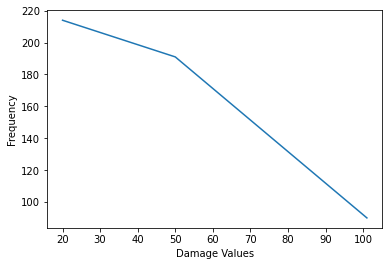

In [3]:
#The Second chosen bins
bins2= [10.0009, 20, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df['DAM_perc_dmg'], bins=bins2)
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:],samples_per_bin2)

In [4]:
print(samples_per_bin2)
print(binsP2)

[214 191  90]
[ 10.0009  20.      50.     101.    ]


In [6]:
#df['DAM_perc_dmg'].value_counts(bins=binsP2)

In [7]:
bin_index2=np.digitize(df['DAM_perc_dmg'], bins=binsP2)

In [8]:
y_input_strat=bin_index2

In [9]:
#the Beginning time to run the model 20 times
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-11-10 01:03:23


In [10]:
#Define empty lists for bins results(test)
test_RMSE_list_bin1=[]
test_RMSE_list_bin2=[]
test_RMSE_list_bin3=[]


#Define empty lists for bins results(train)
train_RMSE_list_bin1=[]
train_RMSE_list_bin2=[]
train_RMSE_list_bin3=[]


In [17]:
#Dropping highly correlated features (correlation value > 0.99) from X data.
features =[
    'HAZ_rainfall_Total', 
    'HAZ_rainfall_max_6h',
    'HAZ_rainfall_max_24h',
    'HAZ_v_max',
    'HAZ_v_max_3',
    'HAZ_dis_track_min',
    'GEN_landslide_per',
    'GEN_stormsurge_per',
    #'GEN_Bu_p_inSSA', 
    #'GEN_Bu_p_LS', 
    'GEN_Red_per_LSbldg',
    'GEN_Or_per_LSblg', 
    'GEN_Yel_per_LSSAb', 
    #'GEN_RED_per_SSAbldg',
    'GEN_OR_per_SSAbldg',
    'GEN_Yellow_per_LSbl',
    'TOP_mean_slope',
    'TOP_mean_elevation_m', 
    'TOP_ruggedness_stdev', 
    #'TOP_mean_ruggedness',
    #'TOP_slope_stdev', 
    'VUL_poverty_perc',
    'GEN_with_coast',
    'GEN_coast_length', 
    'VUL_Housing_Units',
    'VUL_StrongRoof_StrongWall', 
    'VUL_StrongRoof_LightWall',
    'VUL_StrongRoof_SalvageWall', 
    'VUL_LightRoof_StrongWall',
    'VUL_LightRoof_LightWall', 
    'VUL_LightRoof_SalvageWall',
    'VUL_SalvagedRoof_StrongWall',
    'VUL_SalvagedRoof_LightWall',
    'VUL_SalvagedRoof_SalvageWall', 
    'VUL_vulnerable_groups',
    'VUL_pantawid_pamilya_beneficiary']
    
# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["DAM_perc_dmg"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

def func(x):
    return np.log(x+1)+1

for i in range(20): 
    X_train, X_test, y_train, y_test = train_test_split(X_scaled,df['DAM_perc_dmg'], stratify=y_input_strat, test_size=0.2)

    
    bin_index_test=np.digitize(y_test, bins=binsP2)
    bin_index_train=np.digitize(y_train, bins=binsP2)
    
###You can test the performance by the following weighted RMSE
    
    #XGBoost Reduced Overfitting
    xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
                       colsample_bynode=0.8, colsample_bytree=0.8, gamma=3, eta=0.01,
                       importance_type='gain', learning_rate=0.1, max_delta_step=0,
                       max_depth=4, min_child_weight=1, missing=1, n_estimators=100, early_stopping_rounds=10,
                       n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
                       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                       silent=None, subsample=0.8, verbosity=1, eval_metric=["rmse", "logloss"]
                     )

    
    eval_set = [(X_test, y_test)]
    xgb_model=xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False, #sample_weight=y_train
    #                  sample_weight=np.log(y_train+1)+1
    #                  sample_weight=pow(y_train, 2)
                     )   
    
    #XGBoost
    #xgb = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, gamma=1, reg_lambda=0.1, colsample_bytree=0.8)
    #xgb_model=xgb.fit(X_train, y_train, #sample_weight=y_train
    #                  sample_weight=np.log(y_train+1)+1
    #                  sample_weight=pow(y_train, 2)
    #                 )
    
    
    X2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    print(est2.summary())
    
    y_pred_train = xgb.predict(X_train)
    mse_train_idx1 = mean_squared_error(y_train[bin_index_train==1], y_pred_train[bin_index_train==1])
    rmse_train_1 = np.sqrt(mse_train_idx1)
    mse_train_idx2 = mean_squared_error(y_train[bin_index_train==2], y_pred_train[bin_index_train==2])
    rmse_train_2 = np.sqrt(mse_train_idx2)
    mse_train_idx3 = mean_squared_error(y_train[bin_index_train==3], y_pred_train[bin_index_train==3])
    rmse_train_3 = np.sqrt(mse_train_idx3)
    

    y_pred = xgb.predict(X_test)
    mse_idx1 = mean_squared_error(y_test[bin_index_test==1], y_pred[bin_index_test==1])
    rmse_1 = np.sqrt(mse_idx1)
    mse_idx2 = mean_squared_error(y_test[bin_index_test==2], y_pred[bin_index_test==2])
    rmse_2 = np.sqrt(mse_idx2)
    mse_idx3 = mean_squared_error(y_test[bin_index_test==3], y_pred[bin_index_test==3])
    rmse_3 = np.sqrt(mse_idx3)

    
    
    print('----- Training_bins_RMSE  ------')
    print(f'Root mean squared error of bins_1: {rmse_train_1:.2f}')
    print(f'Root mean squared error of bins_2: {rmse_train_2:.2f}')
    print(f'Root mean squared error of bins_3: {rmse_train_3:.2f}')

    
    train_RMSE_list_bin1.append(rmse_train_1)
    train_RMSE_list_bin2.append(rmse_train_2)
    train_RMSE_list_bin3.append(rmse_train_3)
    
    
    print('----- Test_bins_RMSE  ------')
    print(f'Root mean squared error of bins_1: {rmse_1:.2f}')
    print(f'Root mean squared error of bins_2: {rmse_2:.2f}')
    print(f'Root mean squared error of bins_3: {rmse_3:.2f}')

    
    test_RMSE_list_bin1.append(rmse_1)
    test_RMSE_list_bin2.append(rmse_2)
    test_RMSE_list_bin3.append(rmse_3)
   
    

Index(['HAZ_rainfall_Total', 'HAZ_rainfall_max_6h', 'HAZ_rainfall_max_24h',
       'HAZ_v_max', 'HAZ_v_max_3', 'HAZ_dis_track_min', 'GEN_landslide_per',
       'GEN_stormsurge_per', 'GEN_Red_per_LSbldg', 'GEN_Or_per_LSblg',
       'GEN_Yel_per_LSSAb', 'GEN_OR_per_SSAbldg', 'GEN_Yellow_per_LSbl',
       'TOP_mean_slope', 'TOP_mean_elevation_m', 'TOP_ruggedness_stdev',
       'VUL_poverty_perc', 'GEN_with_coast', 'GEN_coast_length',
       'VUL_Housing_Units', 'VUL_StrongRoof_StrongWall',
       'VUL_StrongRoof_LightWall', 'VUL_StrongRoof_SalvageWall',
       'VUL_LightRoof_StrongWall', 'VUL_LightRoof_LightWall',
       'VUL_LightRoof_SalvageWall', 'VUL_SalvagedRoof_StrongWall',
       'VUL_SalvagedRoof_LightWall', 'VUL_SalvagedRoof_SalvageWall',
       'VUL_vulnerable_groups', 'VUL_pantawid_pamilya_beneficiary'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     8.228
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           1.00e-26
Time:                        01:06:28   Log-Likelihood:                -1681.4
No. Observations:                 396   AIC:                             3427.
Df Residuals:                     364   BIC:                             3554.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.2466      0.896     34.889      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     8.433
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           1.92e-27
Time:                        01:06:29   Log-Likelihood:                -1668.0
No. Observations:                 396   AIC:                             3400.
Df Residuals:                     364   BIC:                             3527.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.0920      0.863     36.020      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     8.920
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           3.96e-29
Time:                        01:06:30   Log-Likelihood:                -1667.8
No. Observations:                 396   AIC:                             3400.
Df Residuals:                     364   BIC:                             3527.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.2784      0.863     36.229      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     8.132
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           2.18e-26
Time:                        01:06:31   Log-Likelihood:                -1660.8
No. Observations:                 396   AIC:                             3386.
Df Residuals:                     364   BIC:                             3513.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.1263      0.849     36.676      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     9.053
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           1.39e-29
Time:                        01:06:32   Log-Likelihood:                -1673.1
No. Observations:                 396   AIC:                             3410.
Df Residuals:                     364   BIC:                             3538.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.7864      0.875     36.326      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     8.885
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           5.22e-29
Time:                        01:06:33   Log-Likelihood:                -1665.0
No. Observations:                 396   AIC:                             3394.
Df Residuals:                     364   BIC:                             3521.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.0969      0.855     36.369      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     7.886
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           1.62e-25
Time:                        01:06:34   Log-Likelihood:                -1671.4
No. Observations:                 396   AIC:                             3407.
Df Residuals:                     364   BIC:                             3534.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.1110      0.877     35.478      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     8.719
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           1.95e-28
Time:                        01:06:35   Log-Likelihood:                -1667.0
No. Observations:                 396   AIC:                             3398.
Df Residuals:                     364   BIC:                             3525.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.5717      0.864     36.552      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     9.059
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           1.32e-29
Time:                        01:06:36   Log-Likelihood:                -1659.9
No. Observations:                 396   AIC:                             3384.
Df Residuals:                     364   BIC:                             3511.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.0852      0.843     36.892      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     8.425
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           2.03e-27
Time:                        01:06:37   Log-Likelihood:                -1651.7
No. Observations:                 396   AIC:                             3367.
Df Residuals:                     364   BIC:                             3495.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.1195      0.828     37.562      0.0

In [18]:
#the End time of running the model 20 times
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-11-10 01:06:38


stdev_RMSE_test: 5.92
stdev_RMSE_train: 7.54
mean_RMSE_test: 19.72
mean_RMSE_train: 13.90


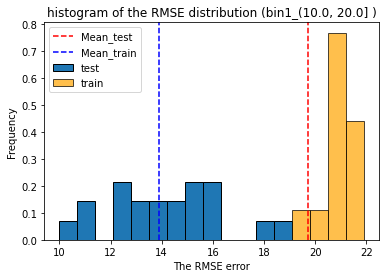

In [19]:
#RMSE of bins_1

m_test_rmse = statistics.mean(test_RMSE_list_bin1)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin1, bins=np.arange(10.0,22.0,0.7), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin1)


m_train_rmse = statistics.mean(train_RMSE_list_bin1)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin1, bins=np.arange(10.0,22.0,0.7), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7, #bins=np.arange(0.8,2.9,0.12)
        )
sd_train_rmse = statistics.stdev(train_RMSE_list_bin1)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin1_(10.0, 20.0] )')
plt.show()

stdev_RMSE_test: 1.76
stdev_RMSE_train: 2.06
mean_RMSE_test: 13.11
mean_RMSE_train: 8.01


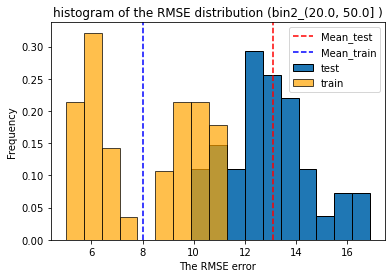

In [20]:
#RMSE of bins_2

m_test_rmse = statistics.mean(test_RMSE_list_bin2)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin2, bins=np.arange(5.0,17.0,0.7), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin2)


m_train_rmse = statistics.mean(train_RMSE_list_bin2)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin2, bins=np.arange(5.0,17.0,0.7), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7, #bins=np.arange(6.0,11.0,0.25)
        )
sd_train_rmse = statistics.stdev(train_RMSE_list_bin2)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin2_(20.0, 50.0] )')
plt.show()

stdev_RMSE_test: 5.36
stdev_RMSE_train: 2.97
mean_RMSE_test: 28.25
mean_RMSE_train: 11.54


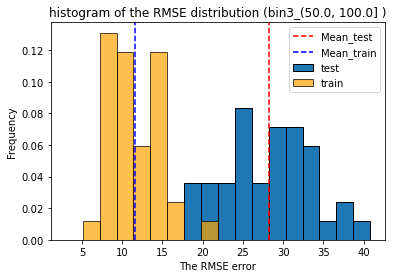

In [21]:
#RMSE of bins_3

m_test_rmse = statistics.mean(test_RMSE_list_bin3)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin3, bins=np.arange(3.0,42.0,2.1), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin3)


m_train_rmse = statistics.mean(train_RMSE_list_bin3)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin3, bins=np.arange(3.0,42.0,2.1), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7)
sd_train_rmse = statistics.stdev(train_RMSE_list_bin3)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin3_(50.0, 100.0] )')
plt.show()